In [ ]:
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle-3.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy
!unzip -q diagnosis-of-diabetic-retinopathy.zip -d retinal_fundus_dataset

Saving kaggle-3.json to kaggle-3.json
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): MIT
  0% 0.00/30.1M [00:00<?, ?B/s]
100% 30.1M/30.1M [00:00<00:00, 1.57GB/s]


In [ ]:
import os
import time
import json
import random
from collections import Counter
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR


import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


from google.colab import files
from torchsummary import summary

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [ ]:
class FundusDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_paths.append(os.path.join(label_dir, img_name))
                    self.labels.append(self.class_to_idx[label])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.img_paths[idx]).convert('RGB')
            label = self.labels[idx]
            one_hot = torch.zeros(len(self.class_to_idx))
            one_hot[label] = 1.0

            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {self.img_paths[idx]}: {e}")
            return None, None

        return image, one_hot

In [ ]:
temp_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor()
])

temp_dataset = FundusDataset('/content/retinal_fundus_dataset/retino/train', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

def compute_dataset_stats(loader):
    mean = 0.0
    std = 0.0
    n_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples
    mean /= n_samples
    std /= n_samples
    return mean, std

mean, std = compute_dataset_stats(temp_loader)
print("Dataset Mean:", mean)
print("Dataset Std:", std)


Dataset Mean: tensor([0.4159, 0.2225, 0.0757])
Dataset Std: tensor([0.2374, 0.1314, 0.0516])


In [ ]:
def count_classes(root_dir):
    class_counts = {}
    for split in ['test',
                  'train',
                  'valid']:
        split_dir = os.path.join(root_dir, split)
        split_counts = Counter()
        for cls_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls_name)
            if os.path.isdir(class_dir):
                count = len([
                    fname for fname in os.listdir(class_dir)
                    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                split_counts[cls_name] = count
        class_counts[split] = dict(split_counts)
    return class_counts


dataset_root = "/content/retinal_fundus_dataset/retino"  
class_distribution = count_classes(dataset_root)

for split, counts in class_distribution.items():
    print(f"\n{split.upper()} CLASS DISTRIBUTION:")
    for cls, count in counts.items():
        print(f"  {cls}: {count}")


TEST CLASS DISTRIBUTION:
  No_DR: 118
  DR: 113

TRAIN CLASS DISTRIBUTION:
  No_DR: 1026
  DR: 1050

VALID CLASS DISTRIBUTION:
  No_DR: 286
  DR: 245


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1)
    ),
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
        contrast=(0.2, 0.8),
        saturation=(0.9, 1.1),
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(
        p=0.25,              
        scale=(0.02, 0.08),  
        ratio=(0.3, 3.3),   
        value="random"   
    )
])

test_val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [8]:
def worker_init_fn(worker_id):
    random.seed(42 + worker_id)
    np.random.seed(42 + worker_id)

g = torch.Generator()
g.manual_seed(42)


train_dataset = FundusDataset('/content/retinal_fundus_dataset/retino/train', transform=train_transform)
val_dataset = FundusDataset('/content/retinal_fundus_dataset/retino/valid', transform=test_val_transform)
test_dataset = FundusDataset('/content/retinal_fundus_dataset/retino/test', transform=test_val_transform)

# Calculate class weights
labels = train_dataset.labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
weights = [class_weights[label] for label in labels]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=os.cpu_count(), worker_init_fn=worker_init_fn, generator=g, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), worker_init_fn=worker_init_fn, generator=g, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), worker_init_fn=worker_init_fn, generator=g, pin_memory=True)


In [ ]:
def eca_kernel_size(channels, gamma=2, b=1):
   
    k = int(abs((math.log2(channels) / gamma) + b))
    if k % 2 == 0:
        k += 1
    return k


class ECABlock(nn.Module):
   
    def __init__(self, channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        k = eca_kernel_size(channels, gamma, b)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=k,
            padding=(k - 1) // 2,
            bias=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        y = self.avg_pool(x)                
        y = y.squeeze(-1).transpose(-1, -2) 
        y = self.conv(y)                    
        y = self.sigmoid(y)
        y = y.transpose(-1, -2).unsqueeze(-1)  
        return x * y.expand_as(x)


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.eca = ECABlock(out_channels)
        self.downsample = downsample

    def forward(self, x):

        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.eca(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  
        out = self.relu(out)
        return out


class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.in_channels = 64

        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        
        self.layer1 = self._make_layer(64, blocks=2, stride=1)
        self.layer2 = self._make_layer(128, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, blocks=2, stride=2)
        self.layer4 = self._make_layer(512, blocks=2, stride=2)

        

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)



    def forward(self, x):

        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
model = ResNet18(num_classes=2) 
model.to(device)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (eca): ECABlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (sigmoid): Sigmoid()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, save_path="best_model.pth"):

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=0.0001,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []
    val_precision_history, val_recall_history, val_f1_history = [], [], []
    val_specificity_history, val_auc_history = [], []

    best_val_acc = 0.0
    best_epoch = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()

        
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            if labels.dim() > 1:
                labels = torch.argmax(labels, dim=1)

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

       
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0
        all_preds, all_labels, all_probs = [], [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                if labels.dim() > 1:
                    labels = torch.argmax(labels, dim=1)

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)

                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        val_loss /= total_val
        val_acc = correct_val / total_val

        
        val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        
        cm = confusion_matrix(all_labels, all_preds)
        specificity_per_class = []
        for i in range(len(cm)):
            tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
            fp = np.sum(cm[:, i]) - cm[i, i]
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
            specificity_per_class.append(specificity)
        val_specificity = np.average(specificity_per_class, weights=np.bincount(all_labels)) if len(np.bincount(all_labels)) > 0 else 0.0

        
        try:
            if len(np.unique(all_labels)) == 2:
                positive_probs = [p[1] for p in all_probs]
                val_auc = roc_auc_score(all_labels, positive_probs)
            else:
                val_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
        except ValueError:
            val_auc = 0.0

        # Append validation metrics
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_precision_history.append(val_precision)
        val_recall_history.append(val_recall)
        val_f1_history.append(val_f1)
        val_specificity_history.append(val_specificity)
        val_auc_history.append(val_auc)

        # === Save best model by val_acc ===
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved at epoch {best_epoch} with val_acc: {best_val_acc:.4f}")
            print(f"Confusion Matrix (Val):\n{cm}")

        scheduler.step()
        epoch_duration = time.time() - start_time

        # === LOG ===
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train: Loss={train_loss:.4f}, Acc={train_acc*100:.2f}%")
        print(f"Val:   Loss={val_loss:.4f}, Acc={val_acc*100:.2f}%, Precision={val_precision*100:.2f}%, Recall={val_recall*100:.2f}%, "
              f"Specificity={val_specificity*100:.2f}%, F1={val_f1*100:.2f}%, AUC={val_auc*100:.2f}%")
        print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
        print(f"Epoch duration: {epoch_duration:.2f} seconds")
        print("*" * 100)

    print(f" Best model was from epoch {best_epoch} with val_acc: {best_val_acc:.4f}, saved to '{save_path}'")

    return (
        train_loss_history, val_loss_history,
        train_acc_history, val_acc_history,
        val_precision_history, val_recall_history,
        val_specificity_history, val_f1_history,
        val_auc_history
    )


In [ ]:
model = ResNet18(num_classes=2)
model.to(device) 

train_loss_history, val_loss_history, train_acc_history, val_acc_history, val_precision_history, val_recall_history, val_specificity_history, val_f1_history, val_auc_history = train_model(
    model, train_loader, val_loader, num_epochs=200, save_path="best_model.pth"
)

New best model saved at epoch 1 with val_acc: 0.8569
Confusion Matrix (Val):
[[200  45]
 [ 31 255]]
Epoch 1/200
Train: Loss=0.6593, Acc=62.48%
Val:   Loss=0.4893, Acc=85.69%, Precision=85.73%, Recall=85.69%, Specificity=85.11%, F1=85.65%, AUC=89.88%
LR: 0.000100
Epoch duration: 7.28 seconds
****************************************************************************************************
Epoch 2/200
Train: Loss=0.5788, Acc=72.16%
Val:   Loss=0.5117, Acc=83.43%, Precision=84.02%, Recall=83.43%, Specificity=82.06%, F1=83.23%, AUC=88.48%
LR: 0.000100
Epoch duration: 4.82 seconds
****************************************************************************************************
Epoch 3/200
Train: Loss=0.4800, Acc=82.27%
Val:   Loss=0.4513, Acc=84.18%, Precision=84.31%, Recall=84.18%, Specificity=84.34%, F1=84.20%, AUC=91.34%
LR: 0.000100
Epoch duration: 4.71 seconds
****************************************************************************************************
New best model saved 

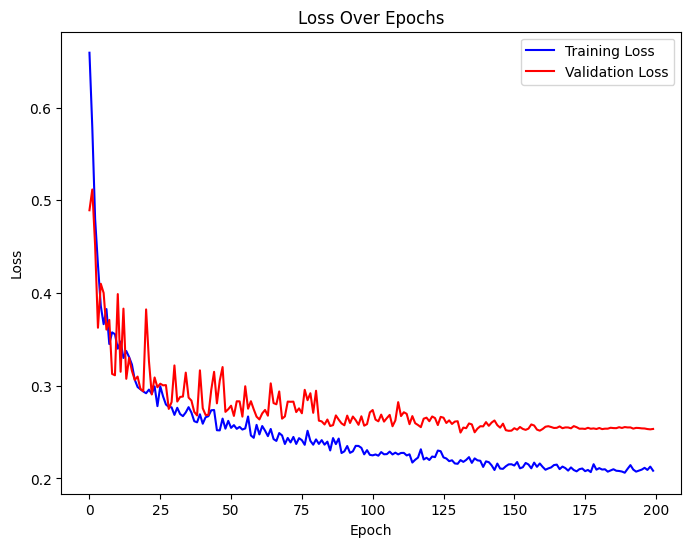

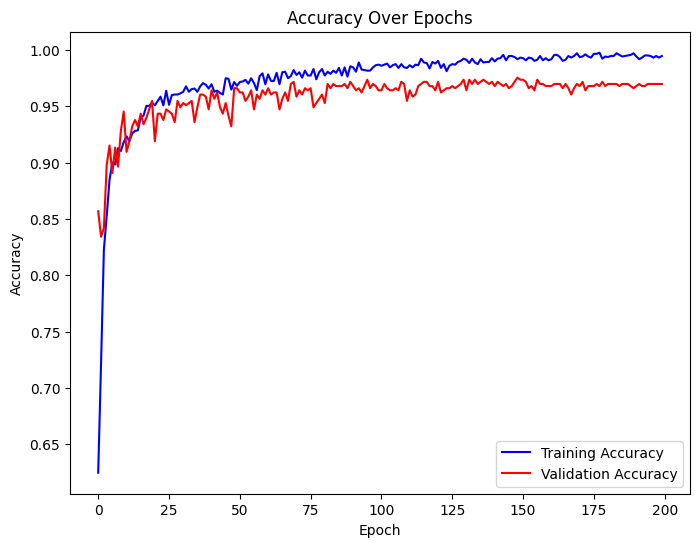

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        
        if labels.dim() > 1:
            _, true_indices = torch.max(labels, 1)
            y_true.extend(true_indices.cpu().numpy())
        else:
            y_true.extend(labels.cpu().numpy())

        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy()) 

class_names = ['DR', 'No_DR']
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

try:
    auc = roc_auc_score(y_true, y_probs)
except ValueError: 
    auc = 0.0



cm = confusion_matrix(y_true, y_pred)

if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
else:
    specificity = 0.0
    print("Warning: Confusion matrix shape is not (2, 2). Specificity calculation skipped.")


print(f"\nFinal Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"F1-score     : {f1:.4f}")
print(f"AUC          : {auc:.4f}")
print(f"Confusion Matrix:\n{cm}")

              precision    recall  f1-score   support

          DR     0.9821    0.9735    0.9778       113
       No_DR     0.9748    0.9831    0.9789       118

    accuracy                         0.9784       231
   macro avg     0.9785    0.9783    0.9783       231
weighted avg     0.9784    0.9784    0.9784       231


Final Evaluation Metrics:
Accuracy     : 0.9784
Precision    : 0.9748
Recall       : 0.9831
Specificity  : 0.9735
F1-score     : 0.9789
AUC          : 0.9774
Confusion Matrix:
[[110   3]
 [  2 116]]


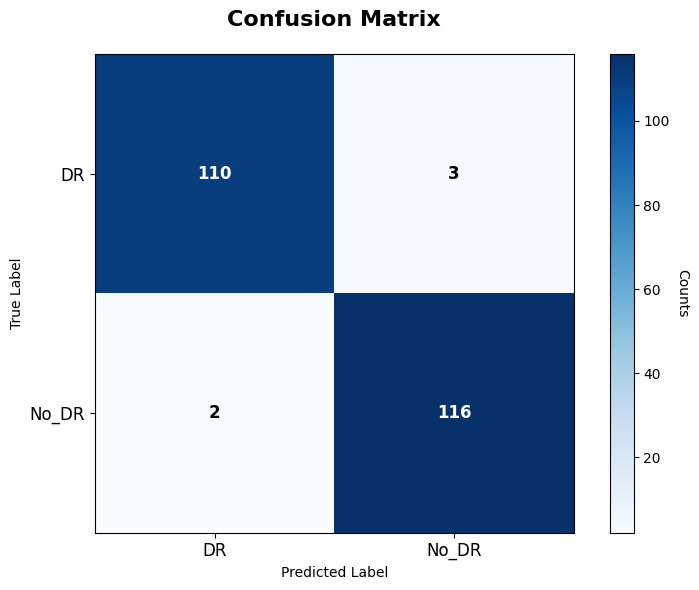

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')


thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight='bold')


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Counts', rotation=-90, va="bottom")


ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)


plt.tight_layout()
plt.show()

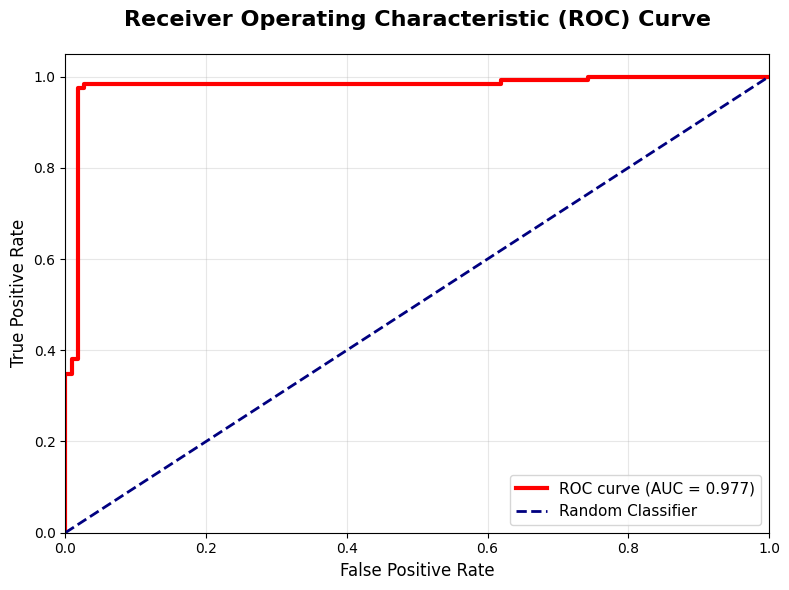

In [ ]:
plt.figure(figsize=(8, 6))

if len(set(y_true)) > 1 and len(set(y_pred)) > 1:

    fpr, tpr, thresholds = roc_curve(y_true, y_probs)


    plt.plot(fpr, tpr, color='red', lw=3,
             label=f'ROC curve (AUC = {auc:.3f})')

 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve',
              fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)



else:
 
    plt.text(0.5, 0.5, 'Insufficient data for ROC\n(Only one class present)',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve (Not Available)', fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()